In [2]:
import pandas as pd
import numpy as np
import datetime

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
faces_df = pd.read_parquet("../data/02_intermediate/faces_dir")

<IPython.core.display.Javascript object>

In [3]:

faces_value_counts = faces_df["name"].value_counts()
faces_df["train_set"] = faces_df["name"].isin(
    np.random.permutation(faces_value_counts.index)[
        : int(0.7 * len(faces_value_counts))
    ]
)
df_input = faces_df[faces_df["train_set"]].drop("train_set", axis=1)
df_validation = faces_df[~faces_df["train_set"]].drop("train_set", axis=1)

<IPython.core.display.Javascript object>

In [4]:
def generate_data(df=df_input, n_sample=100, prop_same=0.5):
    n_same = int(prop_same * n_sample)
    n_dif = n_sample - n_same
    val_counts = df["name"].value_counts()
    val_counts_rep = val_counts[val_counts > 1]
    sample_same = np.random.randint((val_counts_rep).sum(), size=n_same)
    sample_ser_cum = val_counts_rep.cumsum().apply(
        lambda x: sum([x >= y for y in sample_same])
    )
    sample_ser = sample_ser_cum - ([0] + list(sample_ser_cum.values)[:-1])
    while True:
        result_df = pd.DataFrame(columns=["arr_1", "arr_2", "same"])
        cont = 0
        for ind, n in sample_ser[sample_ser > 0].iteritems():
            for i in range(n):
                sample_inds = np.random.choice(
                    df[df["name"] == ind]["address"].values, 2
                )
                result_df.loc[cont] = [
                    (imread(FACES_DIR + "/" + sample_inds[0]) - 255) / 123,
                    (imread(FACES_DIR + "/" + sample_inds[1]) - 255) / 123,
                    True,
                ]
                cont += 1
        for i in range(n_dif):
            ind_1, ind_2 = tuple(np.random.choice(df.index, 2))
            while df.loc[ind_1, "name"] == df.loc[ind_2, "name"]:
                ind_1, ind_2 = tuple(np.random.choice(df.index, 2))
            result_df.loc[cont] = [
                (imread(FACES_DIR + "/" + df.loc[ind_1]["address"]) - 255) / 123,
                (imread(FACES_DIR + "/" + df.loc[ind_2]["address"]) - 255) / 123,
                False,
            ]
            cont += 1
        yield (
            [
                np.concatenate(result_df["arr_1"].apply(lambda x: x[None, :])),
                np.concatenate(result_df["arr_2"].apply(lambda x: x[None, :])),
            ],
            result_df["same"].astype(int).values,
        )

<IPython.core.display.Javascript object>

In [5]:
x, y = next(generate_data(df_input, n_sample=3))

<IPython.core.display.Javascript object>

In [6]:
shape_arr = x[0].shape[1:]
input_face_1 = keras.Input(shape=(shape_arr))
input_face_2 = keras.Input(shape=(shape_arr))

<IPython.core.display.Javascript object>

In [7]:
conv_1 = layers.Conv2D(filters=5, kernel_size=10, strides=(3, 3), activation="relu")
max_pool_1 = layers.MaxPooling2D()
conv_2 = layers.Conv2D(filters=10, kernel_size=4, activation="relu")
max_pool_2 = layers.MaxPooling2D()
conv_3 = layers.Conv2D(filters=15, kernel_size=4, activation="relu")
max_pool_3 = layers.MaxPooling2D()
conv_4 = layers.Conv2D(filters=30, kernel_size=4, activation="relu")
max_pool_4 = layers.MaxPooling2D(pool_size=(4, 4))

<IPython.core.display.Javascript object>

In [8]:
face_1_conv = conv_1(input_face_1)
face_2_conv = conv_1(input_face_2)

face_1_conv = max_pool_1(face_1_conv)
face_2_conv = max_pool_1(face_2_conv)

face_1_conv = conv_2(face_1_conv)
face_2_conv = conv_2(face_2_conv)

face_1_conv = max_pool_2(face_1_conv)
face_2_conv = max_pool_2(face_2_conv)


face_1_conv = conv_3(face_1_conv)
face_2_conv = conv_3(face_2_conv)

face_1_conv = max_pool_3(face_1_conv)
face_2_conv = max_pool_3(face_2_conv)


face_1_conv = conv_4(face_1_conv)
face_2_conv = conv_4(face_2_conv)

face_1_conv = max_pool_4(face_1_conv)
face_2_conv = max_pool_4(face_2_conv)


merge_layer = layers.Concatenate()([face_1_conv, face_2_conv])
dense_input = layers.Flatten()(merge_layer)

Metal device set to: Apple M1


2022-06-12 22:55:48.857665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 22:55:48.857909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<IPython.core.display.Javascript object>

In [9]:
dense_1 = layers.Dense(10, activation="relu")(dense_input)
predictions = layers.Dense(1, activation="sigmoid")(dense_1)

<IPython.core.display.Javascript object>

In [10]:
model = keras.Model(inputs=[input_face_1, input_face_2], outputs=predictions)

<IPython.core.display.Javascript object>

In [11]:
model.compile(
    "adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

<IPython.core.display.Javascript object>

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 81, 81, 5)    1505        ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

<IPython.core.display.Javascript object>

In [13]:
data_generator = generate_data(n_sample=100)
val_generator = generate_data(df_validation, n_sample=100)

<IPython.core.display.Javascript object>

In [15]:
model.predict()

<IPython.core.display.Javascript object>

In [25]:
loss_train = []
loss_cv = []

<IPython.core.display.Javascript object>

In [28]:
for i in range(200):
    if i % 50 == 0:
        print(f'Iteration: {i} - time: {datetime.datetime.now().strftime("%H:%M:%S")}')
    x, y = next(data_generator)
    val_data = next(val_generator)
    model_fit = model.fit(
        x=x,
        y=y,
        use_multiprocessing=True,
        verbose=i % 50 == 0,
        validation_data=val_data,
    )
    loss_train += model_fit.history["loss"]
    loss_cv += model_fit.history["val_loss"]

Iteration: 0 - time: 23:07:07
4/4 [==============================] - 1s 157ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.4900
Iteration: 50 - time: 23:08:22
4/4 [==============================] - 1s 166ms/step - loss: 0.7010 - accuracy: 0.5900 - val_loss: 0.7276 - val_accuracy: 0.4900
Iteration: 100 - time: 23:09:54
4/4 [==============================] - 1s 163ms/step - loss: 0.6687 - accuracy: 0.6100 - val_loss: 0.6947 - val_accuracy: 0.5300
Iteration: 150 - time: 23:11:12
4/4 [==============================] - 1s 157ms/step - loss: 0.6747 - accuracy: 0.5900 - val_loss: 0.7017 - val_accuracy: 0.5600


<IPython.core.display.Javascript object>

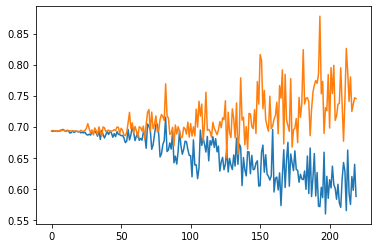

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots()
ax.plot(loss_train)
ax.plot(loss_cv)